In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


temp_cols = [f'col_{i}' for i in range(10)]
df_raw = pd.read_csv('content_activity.csv', names=temp_cols, header=None,
                     skiprows=1, index_col=False, on_bad_lines='skip', engine='python')

# Map and repair columns
df = pd.DataFrame()
df['user_id'] = df_raw['col_0']
df['timestamp'] = pd.to_datetime(df_raw['col_1'], errors='coerce')
df['hour'] = df['timestamp'].dt.hour
df['day_name'] = df['timestamp'].dt.day_name()

df['ip_address'] = df_raw['col_2']
# Stitch fragments of User Agent
df['user_agent'] = df_raw.iloc[:, 3:].fillna('').agg(','.join, axis=1).str.strip(',')

# Clean and split IP (Handle the 'Public|Internal' format)
df = df.dropna(subset=['timestamp'])
df[['public_ip', 'internal_ip']] = df['ip_address'].str.split('|', expand=True, n=1)

print(f"Data Loaded: {df.shape[0]} rows")

Data Loaded: 1350964 rows


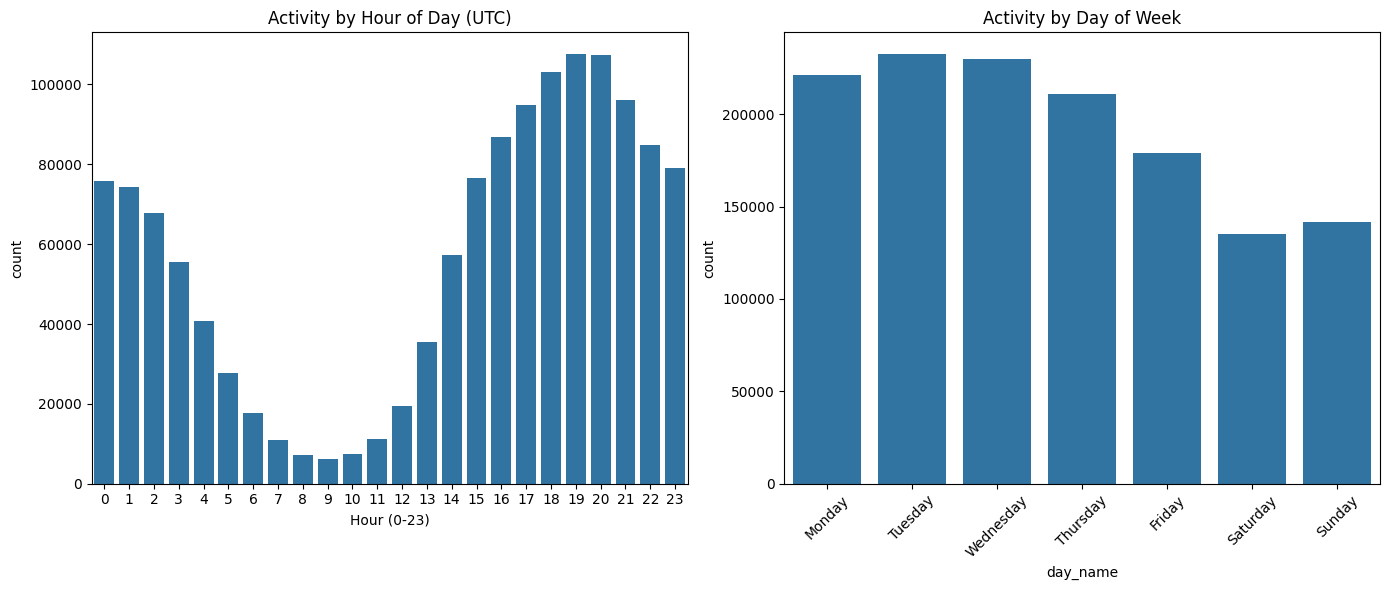

In [79]:
# Temporal Activity Patterns
# Helps identify if activity is human-like or consistent across all timezones

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=df, x='hour')
plt.title('Activity by Hour of Day (UTC)')
plt.xlabel('Hour (0-23)')

plt.subplot(1, 2, 2)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='day_name', order=day_order)
plt.title('Activity by Day of Week')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

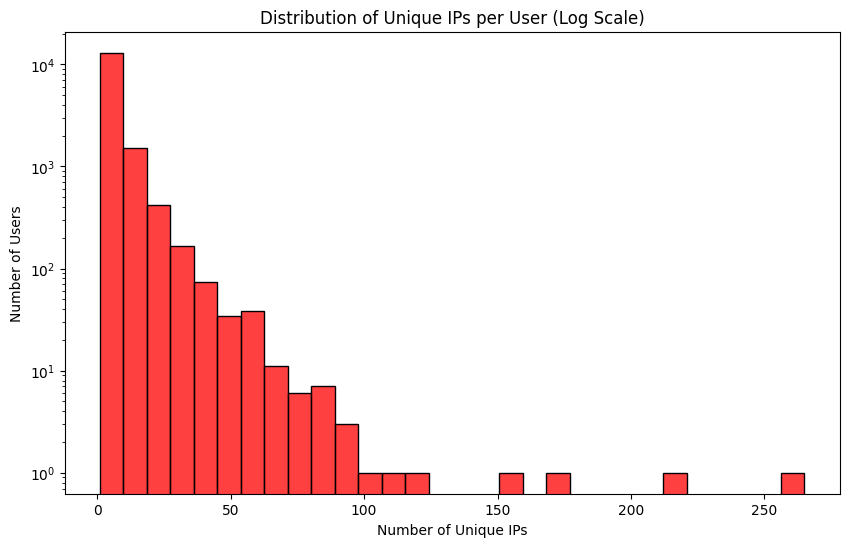

Average IPs per user: 5.40
Max IPs by a single user: 265


In [80]:
# Calculate IPs per user
ip_counts = df.groupby('user_id')['public_ip'].nunique().reset_index(name='unique_ips')

plt.figure(figsize=(10, 6))
sns.histplot(ip_counts['unique_ips'], bins=30, kde=False, color='red')
plt.yscale('log') # Log scale to see the few users with high IP counts
plt.title('Distribution of Unique IPs per User (Log Scale)')
plt.xlabel('Number of Unique IPs')
plt.ylabel('Number of Users')
plt.show()

print(f"Average IPs per user: {ip_counts['unique_ips'].mean():.2f}")
print(f"Max IPs by a single user: {ip_counts['unique_ips'].max()}")

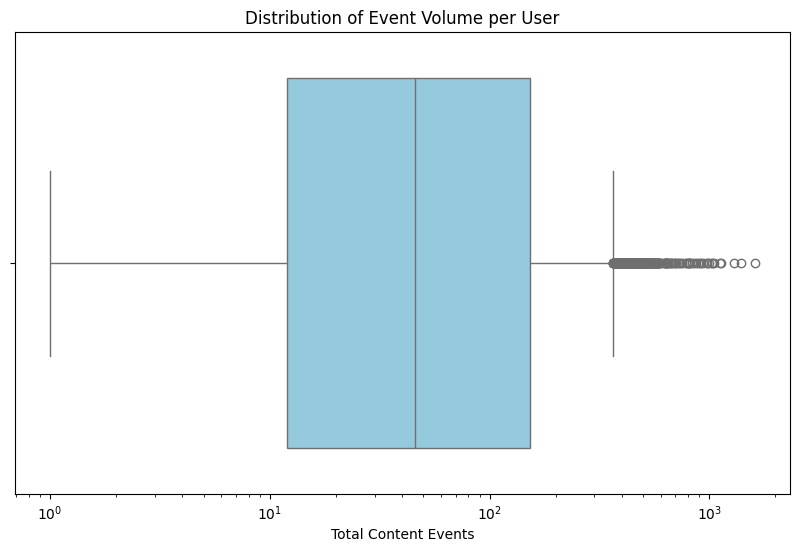

In [81]:
# Events per User
user_volume = df.groupby('user_id').size().reset_index(name='event_count')

plt.figure(figsize=(10, 6))
sns.boxplot(x=user_volume['event_count'], color='skyblue')
plt.title('Distribution of Event Volume per User')
plt.xlabel('Total Content Events')
plt.xscale('log')
plt.show()

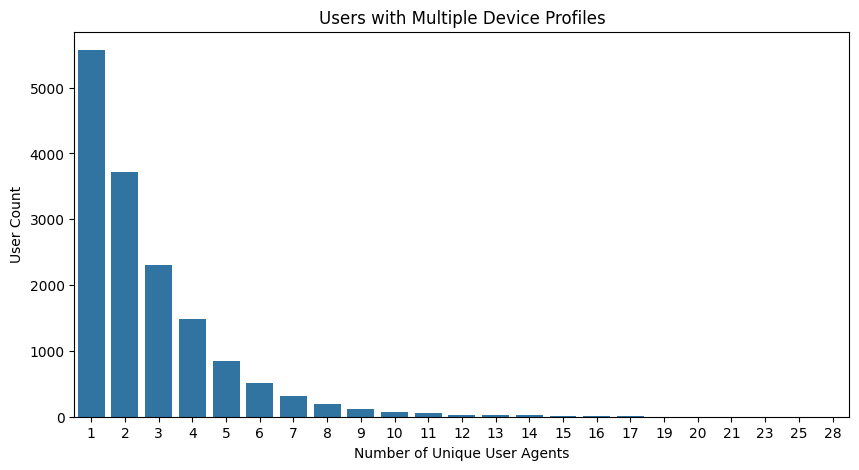

In [82]:
# Device Profile Diversity
# High diversity in a short time is a strong signal for sharing
df['ua_hash'] = df['user_agent'].apply(hash) # Simple proxy for unique device profiles
ua_diversity = df.groupby('user_id')['ua_hash'].nunique().reset_index(name='unique_devices')

plt.figure(figsize=(10, 5))
sns.countplot(data=ua_diversity, x='unique_devices')
plt.title('Users with Multiple Device Profiles')
plt.xlabel('Number of Unique User Agents')
plt.ylabel('User Count')
plt.show()